In [2]:
import os, glob, csv, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.metrics import r2_score, explained_variance_score

In [3]:
def make_pred_df():
    
#     cls_files = glob.glob(r'../results/eye-movement-prediction/preds_probing/*cls.tsv')
    mean_files = glob.glob(r'../results/eye-movement-prediction/preds_probing/*mean.tsv')

#     # Read in files as dataframes + add column with filenames
#     cls_dfs = []
#     for file in cls_files:
#         df = pd.read_csv(file, sep='\t', names=['feature', 'pred', 'true'])
#         df['file'] = len(df) * [file.lstrip('../results/eye-movement-prediction/preds_probing\probe_xlm-')]
#         df['pred'] = [float(pred.lstrip('[').rstrip(']')) for pred in df['pred'].tolist()]
#         df['true'] = [float(true.lstrip('[').rstrip(']')) for true in df['true'].tolist()]
#         df['fold'] = len(df) * [file[-9]]
#         df['pooling'] = len(df) * ['cls']
#         cls_dfs.append(df)
#     cls_preds = pd.concat(cls_dfs, axis=0, ignore_index=True)

    mean_dfs = []
    for file in mean_files:
        df = pd.read_csv(file, sep='\t', names=['feature', 'pred', 'true'])
        df['file'] = len(df) * [file.lstrip('../results/eye-movement-prediction/preds_probing\probe_xlm-')]
        df['pred'] = [float(pred.lstrip('[').rstrip(']')) for pred in df['pred'].tolist()]
        df['true'] = [float(true.lstrip('[').rstrip(']')) for true in df['true'].tolist()]
        df['fold'] = len(df) * [file[-10]]
        mean_dfs.append(df)
    mean_preds = pd.concat(mean_dfs, axis=0, ignore_index=True)
    
#     all_preds = pd.concat([cls_preds, mean_preds], axis=0, ignore_index=True)
    
    mean_preds['language'] = [file[:7].strip('-') for file in mean_preds['file']]
    mean_preds['model'] = ['finetuned' if 'finetuned' in file else 'pretrained' for file in mean_preds['file']]
    
    return mean_preds

make_pred_df()

,feature,pred,true,file,fold,language,model
0,scaled_token_count,28.692120,24.528301,English-finetuned-fold_0-mean.tsv,0,English,finetuned
1,scaled_token_count,34.985374,47.169810,English-finetuned-fold_0-mean.tsv,0,English,finetuned
2,scaled_token_count,33.115982,30.188679,English-finetuned-fold_0-mean.tsv,0,English,finetuned
3,scaled_token_count,26.210050,5.660379,English-finetuned-fold_0-mean.tsv,0,English,finetuned
4,scaled_token_count,32.751198,35.849056,English-finetuned-fold_0-mean.tsv,0,English,finetuned
...,...,...,...,...,...,...,...
53995,scaled_n_low_freq_words,30.944254,33.333336,Turkish-pretrained-fold_4-mean.tsv,4,Turkish,pretrained
53996,scaled_n_low_freq_words,27.218801,13.333334,Turkish-pretrained-fold_4-mean.tsv,4,Turkish,pretrained
53997,scaled_n_low_freq_words,27.295258,33.333336,Turkish-pretrained-fold_4-mean.tsv,4,Turkish,pretrained
53998,scaled_n_low_freq_words,31.092789,26.666668,Turkish-pretrained-fold_4-mean.tsv,4,Turkish,pretrained


In [4]:
def evaluate(pred_df):
    
    exp_var = explained_variance_score(pred_df['true'], pred_df['pred'])
    r2 = r2_score(pred_df['true'], pred_df['pred'])
    
    return exp_var, r2

In [5]:
def make_eval_df(pred_df):

    languages = []
    models = []
    exp_var_scores = []
    r2_scores = []
    folds = []
    features = []

    for (model, lang, fold, feature), group in pred_df.groupby(['model', 'language', 'fold', 'feature']):
        
        # evaluate
        exp_var, r2 = evaluate(group)

        # collect information
        languages.append(lang)
        models.append(model)
        folds.append(fold)
        features.append(feature)
        exp_var_scores.append(exp_var)
        r2_scores.append(r2)

    # make df
    eval_df = pd.DataFrame()
    eval_df['model'] = models
    eval_df['language'] = languages
    eval_df['fold'] = folds
    eval_df['feature'] = features
    eval_df['exp_var'] = exp_var_scores
    eval_df['r2'] = r2_scores
    
    return eval_df

In [6]:
eval_df = make_eval_df(make_pred_df())
finetuned_df = eval_df.groupby('model').get_group('finetuned')
pretrained_df = eval_df.groupby('model').get_group('pretrained')

In [7]:
r2_diffs = np.array(finetuned_df['r2']) - np.array(pretrained_df['r2'])
ev_diffs = np.array(finetuned_df['exp_var']) - np.array(pretrained_df['exp_var'])
finetuned_df['r2_diff'] = r2_diffs.tolist()
finetuned_df['ev_diff'] = ev_diffs.tolist()
finetuned_df

<ipython-input-7-6cb832c9b6e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finetuned_df['r2_diff'] = r2_diffs.tolist()
<ipython-input-7-6cb832c9b6e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finetuned_df['ev_diff'] = ev_diffs.tolist()


,model,language,fold,feature,exp_var,r2,r2_diff,ev_diff
0,finetuned,English,0,scaled_avg_links_len,0.028880,-0.017867,0.212437,0.031821
1,finetuned,English,0,scaled_avg_max_depth,0.000000,0.000000,0.000000,0.000000
2,finetuned,English,0,scaled_avg_token_freq,0.003862,-0.001280,0.014565,0.006510
3,finetuned,English,0,scaled_avg_word_length,0.017790,0.017417,0.019096,0.018773
4,finetuned,English,0,scaled_lexical_density,-0.011331,-0.013417,-0.015114,-0.014138
...,...,...,...,...,...,...,...,...
130,finetuned,Turkish,4,scaled_lexical_density,-0.002051,-0.004070,-0.000403,-0.000838
131,finetuned,Turkish,4,scaled_max_links_len,0.082408,0.081086,0.084694,0.075840
132,finetuned,Turkish,4,scaled_n_low_freq_words,0.146356,0.119121,0.138585,0.134932
133,finetuned,Turkish,4,scaled_token_count,0.267134,0.263055,0.262438,0.257068


In [8]:
# stats = finetuned_df.groupby(['language', 'feature']).describe()
# stats

def get_color_scheme(r2_values):
    colors = []
    for value in r2_values:
        if value < 0:
            colors.append('m')
        else:
            colors.append('c')
    return colors

<ipython-input-12-50465cdfc541>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finetuned_df['r2_diff'] = r2_diffs.tolist()
<ipython-input-12-50465cdfc541>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finetuned_df['ev_diff'] = ev_diffs.tolist()


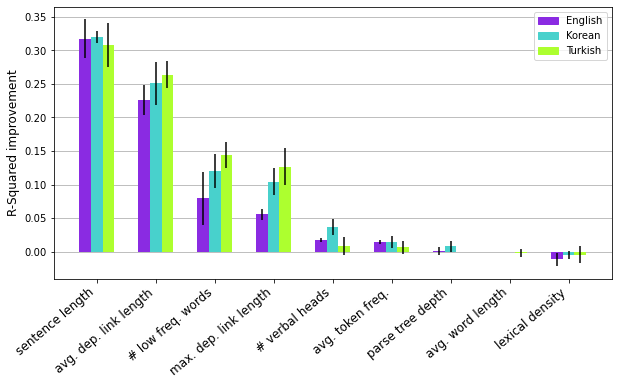

In [12]:
import matplotlib.patches as mpatches

eval_df = make_eval_df(make_pred_df())
finetuned_df = eval_df.groupby('model').get_group('finetuned')
pretrained_df = eval_df.groupby('model').get_group('pretrained')
r2_diffs = np.array(finetuned_df['r2']) - np.array(pretrained_df['r2'])
ev_diffs = np.array(finetuned_df['exp_var']) - np.array(pretrained_df['exp_var'])
finetuned_df['r2_diff'] = r2_diffs.tolist()
finetuned_df['ev_diff'] = ev_diffs.tolist()

languages = ['English', 'Korean', 'Turkish']
colors = ['blueviolet', 'mediumturquoise', 'greenyellow']

features = list(set(eval_df['feature']))
n=-0.2
c=0
plt.figure(figsize=(10,5))

for language in languages:

    eval_df_target = finetuned_df.groupby('language').get_group(language).reset_index(drop=True)

    all_data = []
    
    for feature in features:

        df_feature = eval_df_target.groupby('feature').get_group(feature).reset_index(drop=True)
        scores = df_feature.describe()
 
        all_data.append([f'{feature}', 
                               scores['r2_diff']['mean'],
                               scores['ev_diff']['mean'],
                               scores['r2_diff']['std'],
                               scores['ev_diff']['std']])

    # order data by r2 score
    df_all_data = pd.DataFrame(all_data, columns=['feature', 'r2_diff', 'ev_diff', 'r2_diff_std', 'ev_diff_std'])

    df_all_data_sorted = df_all_data.sort_values(by=['r2_diff'], ascending=False).reset_index(drop=True)
    
    x = np.arange(9)
    y = df_all_data_sorted['r2_diff']
    width = 0.2
    plt.bar(x+n, y, width, yerr = df_all_data_sorted['r2_diff_std'], zorder=3,color=colors[c])
    n+=0.2
    c+=1
    
    labels = ['sentence length', 'avg. dep. link length', '# low freq. words', 'max. dep. link length', '# verbal heads',
             'avg. token freq.', 'parse tree depth', 'avg. word length', 'lexical density']
    #plt.title(feature)
    plt.xticks(ticks=[0,1,2,3,4,5,6,7,8],labels=labels, rotation=40, horizontalalignment='right', fontsize=12)
    plt.grid(axis='y', zorder=0)
    plt.ylabel(f'R-Squared improvement', fontsize=12)
    e_patch = mpatches.Patch(color=colors[0], label='English')
    k_patch = mpatches.Patch(color=colors[1], label='Korean')
    t_patch = mpatches.Patch(color=colors[2], label='Turkish')
    plt.legend(handles=[e_patch, k_patch, t_patch], loc='upper right')

    plt.savefig(f'mean-probing.pdf', dpi=300, bbox_inches='tight')